In [1]:
import centralized as CP
import davisyin as DY
import admm as admm
import numpy as np
from numpy.linalg import inv
from numpy import linalg as LA
from numpy.linalg import inv
import matplotlib.pyplot as plt
import proyecciones as pro
import time
import briceno as BA

In [2]:
# Seteamos los parámetros:
N, M = 3, 5  # Son 2 tecnologías, 10 escenarios.

# Probabilidades:

Sigma = np.ones((1,M))
Sigma /= Sigma.sum()
    
# Parámetros funciones:
I    = 50 * np.ones((N, 1))
MC   = np.array([np.diag(1000*np.ones(N)) for m in range(M)])
VOLL = 10000.0
D    = 1000.0*np.ones((1,M))

e1  = VOLL*1.1
e2  = VOLL*1.1
e31 = VOLL*1.1
e32 = VOLL*1.1

Q1, B1 = np.zeros((N,N)), I
Q2, B2 = 0.01*MC, np.zeros((N,M))
Q3, B3 = np.zeros((1,M)), VOLL*np.ones((1,M))
    

frobenius_norm_of_MC = (e1+e2)*N*0.5+e31+e32+np.array([LA.norm(np.einsum('i,ikl->ikl',Sigma[0],0.01*MC)[xi], 'fro') for xi in range(M)]).sum()

def Grad_Phi_1(x1, Q_1 = np.zeros((N,N)), B_1 = I, e1 = e1, N = N):
    return np.dot(Q_1,x1)+B_1 - e1*np.dot(np.identity(N),np.maximum(-x1,0))

    # me queda e2 * max{0,-x2}
def Grad_Phi_2(x2, Q_2 = 0.01*MC, B_2 = np.zeros((N,M)), e2 = e2, N = N, M = M):
    
    return np.einsum('ijk,ki->ji', Q_2, x2)+B_2 - e2*np.einsum('ijk,ki->ji', np.array([np.diag(np.ones(N)) for m in range(M)]), np.maximum(-x2,0))

    # me queda e31 * max{0,-x3} &  e32 * max{0,-D+x3}
def Grad_Phi_3(x3, Q_3 = np.zeros((1,M)), B_3 = VOLL*np.ones((1,M)), D=D, e31=e31, e32= e32, M = M):
    return Q_3*x3+B_3 - e31*np.dot(np.maximum(-x3,0),np.identity(M)) - e32*np.dot(np.maximum(-D+x3,0),np.identity(M))

    
def Grad_Phi(x1,x2,x3, P = Sigma):
        return Grad_Phi_1(x1), P*Grad_Phi_2(x2), P*Grad_Phi_3(x3)

In [5]:
x1, x2, x3, rho = CP.modelo()

DY_list   = DY.Davis_Yin(N, M, frobenius_norm_of_MC, Grad_Phi, 30000, D)
ADMM_list = admm.ADMM(30000, N, M, (Q1,B1), (Q2,B2), (Q3,B3), Sigma, D, e1, e2, e31, e32)
BA_list   = BA.Briceno_Arias(N, M, 30000, frobenius_norm_of_MC, Grad_Phi, Sigma, D)

In [16]:
BA_list[-1]

((array([[375.17505402, 375.17505402, 375.17505402, 375.17505402,
          375.17505402],
         [375.13569894, 375.13569894, 375.13569894, 375.13569894,
          375.13569894],
         [374.9402494 , 374.9402494 , 374.9402494 , 374.9402494 ,
          374.9402494 ]]),
  array([[333.45228472, 333.43613818, 333.43215247, 333.43423558,
          333.42474321],
         [333.43510781, 333.42305392, 333.42756795, 333.4324792 ,
          333.44228891],
         [333.41545423, 333.44365466, 333.44312634, 333.43613198,
          333.43581464]]),
  array([[333.45228472, 333.43613818, 333.43215247, 333.43423558,
          333.42474321],
         [333.43510781, 333.42305392, 333.42756795, 333.4324792 ,
          333.44228891],
         [333.41545423, 333.44365466, 333.44312634, 333.43613198,
          333.43581464]]),
  array([[-0.30284676, -0.30284676, -0.30284676, -0.30284676, -0.30284676]])),
 'infactible')

In [26]:
def generate_list(lista, algoritmo, solution, objective_function, Demanda):
    
    # unpack solution
    x1, x2, x3 = map(np.array, solution)

    # create a list with index of graphics
    iterations = list(range(len(lista)))
    
    # create list to return
    x_solution   = []
    Fx_solution  = []
    Non_anti_sol = []
    equili_solut = []
    
    
    # create arrays for each graph
    for x_algo, x_fact in lista:
        
        if algoritmo == "DY":
            x1_algo, x2_algo, x3_algo = x_algo
            
        elif algoritmo == "ADMM":
            x1_algo, x2_algo, x3_algo = x_algo[0]
            
        elif algoritmo == "BA":
            x1_algo, x2_algo, _, x3_algo = x_algo
            # x2_algo y _ tienen el mimso valor por componente
            
    
        x_solution.append( LA.norm(x1_algo - x1) + LA.norm(x2_algo - x2.T) + LA.norm(x3_algo - x3) )
        Fx_solution.append( objective_function(x1_algo, x2_algo, x3_algo) - objective_function(x1, x2, x3) )
        Non_anti_sol.append( LA.norm(x1_algo - np.roll(x1_algo, 1, axis=1)) ) #No aplica a DY
        equili_solut.append( LA.norm( x2_algo.sum(axis=0) - (D - x3_algo) ) )
            
    return iterations, x_solution, Fx_solution, Non_anti_sol, equili_solut

In [27]:
generate_list(DY_list, "DY", (x1, x2, x3), Grad_Phi, D)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (5,3,3)->(3,5,3) (5,3)->(3,5) 

Text(0.5, 0.98, 'Subtitulo')

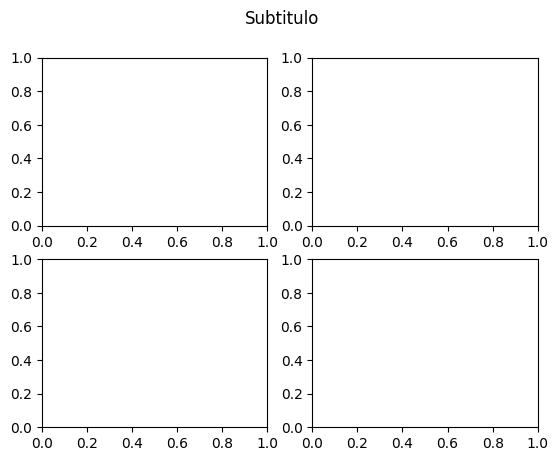

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Subtitulo')


ax1.plot(x1, y1, 'o-')
ax1.set_ylabel('Damped oscillation')

# Esto es "X_al - x_CP"

# Esto es "f(x_al)-f(x_cp)"

# ||x1_i - x2_i|| (Non Anticipatividad)

# || 1I x2 + x3 - D || (Equilibrio)